In [397]:
'''
【项目08】  电商打折套路解析

作业要求
1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少
   
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
提示：
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路

'''

"\n【项目08】  电商打折套路解析\n\n作业要求\n1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”\n要求：\n① 计算得到：商品总数、品牌总数\n② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）\n③ 未参与双十一当天活动的商品，在双十一之后的去向如何？\n④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？\n   * 用bokeh绘制柱状图表示\n提示：\n① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称\n   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）\n② 数据的“店名”字段为品牌的唯一标识\n③ 按照商品销售节奏分类，我们可以将商品分为7类\n   A. 11.11前后及当天都在售 → 一直在售\n   B. 11.11之后停止销售 → 双十一后停止销售\n   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售\n   D. 11.11开始销售且当天停止 → 仅双十一当天有售\n   E. 11.5 - 11.10 → 双十一前停止销售\n   F. 仅11.11当天停止销售 → 仅双十一当天停止销售\n   G. 11.12开始销售 → 双十一后上架\n④ 未参与双十一当天活动的商品，可能有四种情况：\n   con1 → 暂时下架（F）\n   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')\n   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）\n   con4 → 彻底下架（E中部分数据），可忽略\n⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）\n   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少\n   \n2、哪些商品真的在打折呢？\n要求：\n① 针对每个商品，评估其打折的情况\n② 针对在打折的商品，其折扣率是多少\n   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量\n③ 按照品牌分析，不同品牌的打折力

In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [399]:
# 加载数据

salesData = pd.read_excel('/Users/johnnie/Desktop/双十一淘宝美妆数据.xlsx')

In [400]:
salesData.head()

,update_time,id,title,price,店名
0,2016-11-14,A2251521828,相宜本草四倍多萃润泽精华保湿霜滋润面霜女补水,79.0,相宜本草
1,2016-11-14,A2251610120,正品相宜本草四倍多萃润泽洁面膏深层清洁滋润补水保湿,29.0,相宜本草
2,2016-11-14,A2251615486,相宜本草红石榴亮白嫩肤水女紧致补水保湿精华爽肤水女秋冬护肤品,108.0,相宜本草
3,2016-11-14,A2252191048,相宜本草红石榴鲜活透亮面贴膜7片补水保湿女化妆品滋润,79.0,相宜本草
4,2016-11-14,A2253094636,相宜本草去死皮膏洁净面部全身温和去角质补水化妆,35.0,相宜本草


In [401]:
salesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27642 entries, 0 to 27641
Data columns (total 5 columns):
update_time    27642 non-null datetime64[ns]
id             27642 non-null object
title          27642 non-null object
price          27642 non-null float64
店名             27642 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.1+ MB


In [402]:
salesData.describe()

,price
count,27642.000000
mean,362.719694
std,614.024602
min,1.000000
25%,99.000000
50%,205.000000
75%,390.000000
max,11100.000000


In [403]:
# 1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
# ① 计算得到：商品总数、品牌总数

# 商品总数
total_prods = len(salesData['id'].unique())
print("商品总数为：", total_prods)

# 品牌总数
total_brands = len(salesData['店名'].unique())
print("品牌总数为：", total_brands)

商品总数为： 3502
品牌总数为： 22


In [404]:
# 根据商品销售节奏，将商品分为7类：

# A. 统计双11前后及当天都一直在售的商品

bool_value_always_online = salesData[salesData['update_time'] > '2016-11-11']['id'].isin(salesData[salesData['update_time'] <= '2016-11-11']['id'].unique())
salesData1 = salesData[salesData['update_time'] > '2016-11-11'][bool_value_always_online == True]

p1 = salesData1.groupby(['店名'])['id'].value_counts()
o1 = p1.reset_index(level='店名').groupby(['店名'])['id'].count()
o1

店名
SKII     27
佰草集     176
倩碧      136
兰芝       66
兰蔻       90
妮维雅     106
娇兰       84
悦诗风吟    272
植村秀      48
欧珀莱      93
欧莱雅     175
玉兰油     101
相宜本草     98
美加净     160
美宝莲      52
自然堂      77
薇姿       46
蜜丝佛陀     29
资生堂      60
雅漾       62
雅诗兰黛     98
雪花秀      45
Name: id, dtype: int64

In [405]:
# B. 统计双11之后停止销售的商品

bool_value_end_11 = salesData[salesData['update_time'] > '2016-11-11']['id'].isin(salesData[salesData['update_time'] <= '2016-11-11']['id'].unique())
salesData2 = salesData[salesData['update_time'] > '2016-11-11'][bool_value_end_11 == False]

p2 = salesData2.groupby(['店名'])['id'].value_counts()
o2 = p2.reset_index(level='店名').groupby(['店名'])['id'].count()
o2

店名
佰草集      2
兰芝       1
兰蔻       2
娇兰       1
悦诗风吟     4
欧珀莱      2
玉兰油      1
自然堂     59
薇姿       3
资生堂      7
雅漾       1
雅诗兰黛     1
Name: id, dtype: int64

In [406]:
# C. 统计双11上架并持续在售的商品

bool_value_after_11 = salesData[salesData['update_time'] < '2016-11-11']['id'].isin(salesData[salesData['update_time'] >= '2016-11-11']['id'].unique())
salesData3 = salesData[salesData['update_time'] < '2016-11-11'][bool_value_after_11 == False]

p3 = salesData3.groupby(['店名'])['id'].value_counts()
o3 = p3.reset_index(level='店名').groupby(['店名'])['id'].count()
o3

店名
SKII    22
佰草集     60
倩碧      62
兰芝      46
兰蔻      33
妮维雅     29
娇兰      38
悦诗风吟    30
植村秀     22
欧珀莱     64
欧莱雅     53
玉兰油     34
相宜本草    49
美加净     28
美宝莲     33
自然堂     19
薇姿      47
蜜丝佛陀    18
资生堂     54
雅漾      12
雅诗兰黛    73
雪花秀     15
Name: id, dtype: int64

In [407]:
# D. 仅双11当天有售

bool_value_only_on_11 = salesData[salesData['update_time'] != '2016-11-11']['id'].isin(salesData[salesData['update_time'] == '2016-11-11']['id'].unique())
salesData4 = salesData[salesData['update_time'] != '2016-11-11'][bool_value_only_on_11 == False]

p4 = salesData4.groupby(['店名'])['id'].value_counts()
o4 = p4.reset_index(level='店名').groupby(['店名'])['id'].count()
o4

店名
SKII    22
佰草集     71
倩碧      67
兰芝      52
兰蔻      56
妮维雅     29
娇兰      58
悦诗风吟    48
植村秀     36
欧珀莱     70
欧莱雅     59
玉兰油     78
相宜本草    75
美加净     64
美宝莲     35
自然堂     89
薇姿      52
蜜丝佛陀    19
资生堂     71
雅漾      21
雅诗兰黛    76
雪花秀     19
Name: id, dtype: int64

In [408]:
# E. 只双11前销售

bool_value_before_11 = salesData[salesData['update_time'] >= '2016-11-11']['id'].isin(salesData[salesData['update_time'] < '2016-11-11']['id'].unique())
salesData5 = salesData[salesData['update_time'] >= '2016-11-11'][bool_value_before_11 == False]

p5 = salesData5.groupby(['店名'])['id'].value_counts()
o5 = p5.reset_index(level='店名').groupby(['店名'])['id'].count()
o5

店名
SKII     2
佰草集     18
倩碧       4
兰芝       8
兰蔻      10
娇兰       2
悦诗风吟     4
欧珀莱      3
欧莱雅      8
玉兰油      1
自然堂     59
薇姿       3
资生堂     12
雅漾       3
雅诗兰黛     3
雪花秀      1
Name: id, dtype: int64

In [409]:
# F. 双11当天不卖，前后都卖

bool_value_not_on_11 = salesData[salesData['update_time'] == '2016-11-11']['id'].isin(salesData[salesData['update_time'] != '2016-11-11']['id'].unique())
salesData6 = salesData[salesData['update_time'] == '2016-11-11'][bool_value_not_on_11 == False]

p6 = salesData6.groupby(['店名'])['id'].value_counts()
o6 = p6.reset_index(level='店名').groupby(['店名'])['id'].count()
o6

店名
佰草集     9
倩碧      1
兰芝      2
资生堂     3
雅漾      2
雅诗兰黛    1
Name: id, dtype: int64

In [410]:
# G. 双11之后才开始销售

bool_value_begin_12 = salesData[salesData['update_time'] <= '2016-11-11']['id'].isin(salesData[salesData['update_time'] > '2016-11-11']['id'].unique())
salesData7 = salesData[salesData['update_time'] <= '2016-11-11'][bool_value_begin_12 == False]

p7 = salesData7.groupby(['店名'])['id'].value_counts()
o7 = p7.reset_index(level='店名').groupby(['店名'])['id'].count()
o7

店名
SKII     35
佰草集     101
倩碧       75
兰芝       89
兰蔻       76
妮维雅      50
娇兰       62
悦诗风吟     54
植村秀      49
欧珀莱      89
欧莱雅      72
玉兰油      40
相宜本草     69
美加净      28
美宝莲      50
自然堂      48
薇姿       52
蜜丝佛陀     25
资生堂      66
雅漾       16
雅诗兰黛    147
雪花秀      24
Name: id, dtype: int64

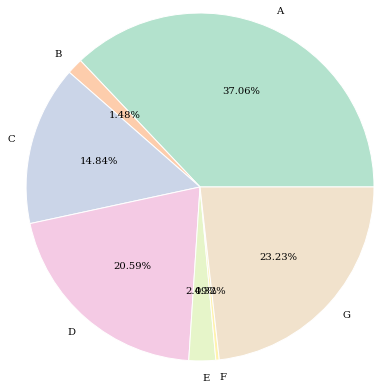

In [411]:
# 上述7中情况的占比分布

import bokeh.palettes as bp
from bokeh.palettes import brewer

total_con = pd.DataFrame(pd.concat([o1, o2, o3, o4, o5, o6, o7], axis=1).fillna(0))
total_con.columns = ['id1','id2','id3','id4','id5','id6','id7']
total_con = total_con.astype('int32')
total = total_con.sum()
total.index = list('ABCDEFG')

colors = brewer['Pastel2'][len(total.index)]

plt.axis('equal')
wedges = plt.pie(total,
        labels=total.index,
        colors=colors,
        autopct='%.2f%%',
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        radius=2)

In [412]:
# ② 双十一当天在售的商品占比情况：去掉双11当天不在售 + 双11前下架 + 双11后上架

sales_not_on_11 = pd.DataFrame(pd.concat([o5, o6, o7], axis=1).fillna(0))
sales_not_on_11.columns = ['id1','id2','id3']
sales_not_on_11['sales_not_on_11'] = sales_not_on_11['id1'] + sales_not_on_11['id2'] + sales_not_on_11['id3'] 
sales_not_on_11 = sales_not_on_11.astype('int32')

sales_on_11 = total_prods - sales_not_on_11['sales_not_on_11'].sum()
sales_on_11_rate = sales_on_11/total_prods
print("双十一当天在售的商品占比情况：%.2f %%" % (sales_on_11_rate * 100))

双十一当天在售的商品占比情况：57.85 %


In [413]:
# ③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
# 分为两种情况：双11前彻底下架 + 双11后重新上架，其实就是E的情况 + F的情况

# 双11前彻底下架，E的情况：

bool_value_before_11 = salesData[salesData['update_time'] >= '2016-11-11']['id'].isin(salesData[salesData['update_time'] < '2016-11-11']['id'].unique())
salesData5 = salesData[salesData['update_time'] >= '2016-11-11'][bool_value_before_11 == False]

p5 = salesData5.groupby(['店名'])['id'].value_counts()
o5 = p5.reset_index(level='店名').groupby(['店名'])['id'].count()
print("双11前彻底下架的商品：\n", o5)

print("-------------------")

# 双11后重新上架，F的情况：

bool_value_not_on_11 = salesData[salesData['update_time'] == '2016-11-11']['id'].isin(salesData[salesData['update_time'] != '2016-11-11']['id'].unique())
salesData6 = salesData[salesData['update_time'] == '2016-11-11'][bool_value_not_on_11 == False]

p6 = salesData6.groupby(['店名'])['id'].value_counts()
o6 = p6.reset_index(level='店名').groupby(['店名'])['id'].count()
print("双11后重新上架的商品：\n", o6)

双11前彻底下架的商品：
 店名
SKII     2
佰草集     18
倩碧       4
兰芝       8
兰蔻      10
娇兰       2
悦诗风吟     4
欧珀莱      3
欧莱雅      8
玉兰油      1
自然堂     59
薇姿       3
资生堂     12
雅漾       3
雅诗兰黛     3
雪花秀      1
Name: id, dtype: int64
-------------------
双11后重新上架的商品：
 店名
佰草集     9
倩碧      1
兰芝      2
资生堂     3
雅漾      2
雅诗兰黛    1
Name: id, dtype: int64


In [414]:
# ④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
# 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品

from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.core.properties import value

# 双十一当天在售的商品
p = salesData.groupby(['店名'])['id'].value_counts()
o = p.reset_index(level='店名').groupby(['店名'])['id'].count()

temp = pd.concat([o, sales_not_on_11], axis=1)
temp['sales_on_11'] = temp['id'] - temp['sales_not_on_11']

sales_on_11 = temp.drop(['id','id1','id2','id3','sales_not_on_11'], axis=1)

# 预售商品
p8 = salesData[salesData['title'].str.contains('预售')].groupby(['店名'])['id'].value_counts()
presell = p8.reset_index(level='店名').groupby(['店名'])['id'].count()

sales = pd.concat([sales_on_11,presell], axis=1)
sales.columns = ['sales_on_11', 'presell']
sales = sales.sort_values('sales_on_11', ascending=False)

# 参与双十一活动的商品数量分布
sales.index.name = 'index'
source = ColumnDataSource(sales)
indexname = sales.index.tolist()

hover = HoverTool(tooltips=[
        ("品牌","@index"),
        ("参与活动商品数","@sales_on_11"),
        ("预售商品数","@presell")
        ])

p = figure(x_range=indexname, plot_height=300, plot_width=900,
            tools=[hover,"wheel_zoom,pan,crosshair,reset"],
            title='各品牌参与双十一活动的商品分布')
p.vbar_stack(['sales_on_11','presell'],
            x='index',
            source=source,
            width=0.9, color=["#718dbf", "#e84d60"], alpha=0.6, line_width=0.2, line_color='white', line_alpha=0.6,
            legend=[value(x) for x in ['sales_on_11','presell']])
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_right"
p.legend.orientation = "horizontal"
show(p)

In [415]:
# 2、哪些商品真的在打折呢？
# ① 针对每个商品，评估其打折的情况

date_bins = pd.to_datetime(['2016-11-05','2016-11-11','2016-11-12','2016-11-15'])
group_names=['双十一前','双十一当天','双十一后']
cats = pd.cut(salesData['update_time'], date_bins, right=False, labels=group_names)
salesData['period'] = cats

discount = salesData.groupby(['id', 'period'])['price'].min().reset_index()
temp1 = salesData[['id','店名']]
temp1.drop_duplicates(inplace=True)
discount = pd.merge(discount, temp1, on='id', how='outer')

on_11 = pd.DataFrame(discount[discount['period'] == '双十一当天'][['id']])
on_11['双十一当天的价格'] = discount[discount['period'] == '双十一当天']['price']

before_11 = pd.DataFrame(discount[discount['period'] == '双十一前'][['id','店名']])
before_11['双十一前的价格'] = discount[discount['period'] == '双十一前']['price']

after_11 = pd.DataFrame(discount[discount['period'] == '双十一后'][['id']])
after_11['双十一后的价格'] = discount[discount['period'] == '双十一后']['price']

before_on_11 = pd.merge(before_11, on_11, how='outer', on='id')
before_on_after_11 = pd.merge(before_on_11, after_11, how='outer', on='id')
before_on_after_11.fillna(0, inplace=True)

discount_filter_con = before_on_after_11[before_on_after_11['双十一当天的价格'] != 0]
discount_filter = discount_filter_con[discount_filter_con['双十一当天的价格'] < discount_filter_con['双十一前的价格']]
discount_filter['打折情况'] = '真打折'
temp2 = discount_filter[['id','打折情况']]

discount = pd.merge(before_on_after_11, temp2, on='id', how='outer')
discount['打折情况'].fillna('不打折', inplace=True)

discount = pd.merge(temp1, discount, on='id')
discount.drop(['店名_y'], axis=1, inplace=True)
discount.columns = ['商品ID','品牌','双十一前的价格','双十一当天的价格','双十一后的价格','打折情况']

discount_prods = discount['打折情况'].value_counts()[1]
print("真打折商品数：", discount_prods)
print("真打折商品占比：%.2f %%" % (discount_prods / total_prods * 100))

真打折商品数： 794
真打折商品占比：22.67 %


In [416]:
# 营销套路1：双11商品价格没有降，反而升了或维持不变

before_on_after_11[(before_on_after_11['双十一当天的价格'] >= before_on_after_11['双十一前的价格']) 
                          & (before_on_after_11['双十一前的价格'] != 0)
                          & (before_on_after_11['双十一当天的价格'] != before_on_after_11['双十一后的价格'])
                          & (before_on_after_11['双十一后的价格'] != 0)].head()

,id,店名,双十一前的价格,双十一当天的价格,双十一后的价格
247,A17924505968,欧莱雅,21.0,62.0,38.0
252,A18056334041,妮维雅,129.0,129.0,118.0
338,A18980833277,自然堂,169.0,179.0,503.0
809,A38618087588,欧莱雅,21.0,62.0,21.0
842,A38960298831,美加净,13.8,39.0,13.8


In [417]:
# 营销套路2：双11之后商品价格没有升，反而降了或维持不变

before_on_after_11[(before_on_after_11['双十一当天的价格'] >= before_on_after_11['双十一后的价格']) 
                          & (before_on_after_11['双十一后的价格'] != 0)
                          & (before_on_after_11['双十一当天的价格'] != before_on_after_11['双十一前的价格'])
                          & (before_on_after_11['双十一前的价格'] != 0)].head()

,id,店名,双十一前的价格,双十一当天的价格,双十一后的价格
1,A10588608182,欧莱雅,249.0,189.0,189.0
17,A12566450440,玉兰油,360.0,270.0,270.0
19,A12577949273,玉兰油,500.0,388.0,388.0
34,A12620554096,相宜本草,178.0,118.0,118.0
56,A12976800504,玉兰油,260.0,199.0,199.0


In [418]:
# ② 针对在打折的商品，其折扣率是多少
# 折扣率 = 双十一当天价格 / 双十一之前价格

temp3 = discount[discount['打折情况'] != '不打折']
temp3['折扣率'] = discount['双十一当天的价格']/discount['双十一前的价格']

temp4 = temp3[['商品ID','折扣率']]

discount_rate = pd.merge(temp4, discount, on='商品ID', how='outer')
discount_rate['折扣率'].fillna(0, inplace=True)
discount_rate['折扣率'] = discount_rate['折扣率'].round(decimals=2) * 10
discount_rate['折扣'] = discount_rate['折扣率']
discount_rate.drop(['折扣率'], axis=1, inplace=True)
discount_rate.head()

,商品ID,品牌,双十一前的价格,双十一当天的价格,双十一后的价格,打折情况,折扣
0,A2251615486,相宜本草,108.0,54.0,79.0,真打折,5.0
1,A2252191048,相宜本草,79.0,39.5,79.0,真打折,5.0
2,A2253281880,相宜本草,22.8,12.9,22.8,真打折,5.7
3,A2253282718,相宜本草,138.0,69.0,138.0,真打折,5.0
4,A2253305238,相宜本草,69.0,34.5,69.0,真打折,5.0


In [419]:
temp5 = pd.DataFrame(discount_rate.groupby(['折扣'])['商品ID'].count().values, index=discount_rate.groupby(['折扣'])['商品ID'].count().index.format(), columns=['amounts'])
temp5.index.name = 'discount'
temp5.iloc[0] = 0
temp5.head()

,amounts
discount,
0.0,0
1.0,1
1.3,1
1.4,1
1.5,2


In [420]:
source = ColumnDataSource(temp5)
indexname = temp5.index.tolist()

hover = HoverTool(tooltips=[
        ("折扣","@discount"),
        ("商品数量","@amounts")
       ])

p = figure(x_range=indexname, plot_height=300, plot_width=1500,
           tools=[hover,"wheel_zoom,pan,crosshair,reset"],
           title='商品折扣统计')
p.line('discount', 'amounts', source=source,
    line_width=1, line_color='black', line_dash=[6,3])
p.circle('discount', 'amounts', source=source,
        size=5, color='red', alpha=0.8)
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
show(p)

In [421]:
# ③ 按照品牌分析，不同品牌的打折力度

from bokeh.transform import jitter

discount_rate.columns = ['ID','Brands','Price_before_11','Price_on_11','Price_after_11','Discount','Discount_rate']
temp6 = discount_rate.groupby(['Brands','ID','Discount_rate']).count().reset_index()
temp6['Discount_rate'].replace([0], np.nan, inplace=True)
temp6.sort_values('ID', inplace=True)

source = ColumnDataSource(temp6)
brands = temp6['Brands'].unique().tolist()

hover = HoverTool(tooltips=[
        ("折扣","@Discount_rate")
       ])

p = figure(y_range=brands, plot_height=400, plot_width=800,
           tools=[hover,"wheel_zoom,pan,crosshair,reset"],
           title='不同品牌折扣统计')
p.circle(x='Discount_rate', y=jitter('Brands', width=0.6, range=p.y_range), source=source,
        size=4, alpha=0.2)
p.ygrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
show(p)

In [422]:
# 3、商家营销套路挖掘？
# ① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路 
temp7 = discount_rate.groupby('Brands')['Discount'].value_counts()
temp = temp7.reset_index(name='Disount_True_or_False')

no_discount = temp[temp['Discount'] == '不打折'][['Brands','Disount_True_or_False']]
yes_discount = temp[temp['Discount'] == '真打折'][['Brands','Disount_True_or_False']]

temp8 = pd.merge(yes_discount, no_discount, on='Brands', how='outer')
temp8.columns = ['Brands', 'Discount: Yes', 'Discount: No']
temp8['Discount: Yes'].fillna(0, inplace=True)
temp8['rate_of_discount_prods'] = temp8['Discount: Yes'] / (temp8['Discount: Yes'] + temp8['Discount: No'])

discount_rate_true = discount_rate[discount_rate['Discount'] == '真打折']
temp9 = discount_rate_true.groupby('Brands')['Discount_rate'].mean()
temp10 = pd.DataFrame(temp9.values, columns=['mean_of_discount_brands'], index=temp9.index)

temp11 = pd.merge(temp8, temp10, left_on='Brands', right_index=True, how='outer')
temp11['mean_of_discount_brands'].fillna(0, inplace=True)
temp11.drop(range(15,22), inplace=True)
temp11['mean_of_discount_brands'] = temp11['mean_of_discount_brands'].round(decimals=1)
temp11['rate_of_discount_prods'] = temp11['rate_of_discount_prods'].round(decimals=3)
temp11['Discount: Yes'] = temp11['Discount: Yes'].astype('int')
temp11.columns = ['Brands', 'amount_of_discount_prods', 'amounts_of_no_discount_prods','rate_of_discount_prods','mean_of_discount_brands']
temp11['amount_of_discount_prods_scaling'] = (temp11['amount_of_discount_prods'] - temp11['amount_of_discount_prods'].min())/(temp11['amount_of_discount_prods'].max() - temp11['amount_of_discount_prods'].min())
temp11['amount_of_discount_prods_scaling']  = temp11['amount_of_discount_prods_scaling'] * 100
temp11

,Brands,amount_of_discount_prods,amounts_of_no_discount_prods,rate_of_discount_prods,mean_of_discount_brands,amount_of_discount_prods_scaling
0,佰草集,186,93,0.667,5.8,100.000000
1,兰芝,4,152,0.026,5.8,1.621622
2,兰蔻,1,167,0.006,7.6,0.000000
3,妮维雅,92,64,0.590,8.9,49.189189
4,娇兰,1,146,0.007,8.0,0.000000
5,悦诗风吟,17,313,0.052,6.2,8.648649
6,欧珀莱,8,176,0.043,5.7,3.783784
7,欧莱雅,80,167,0.324,7.9,42.702703
8,玉兰油,41,101,0.289,8.1,21.621622
9,相宜本草,90,77,0.539,5.3,48.108108


In [423]:
from bokeh.models import Span
from bokeh.models import LabelSet

labels = pd.DataFrame({'x_location': [0.1, 0.45, 0.1, 0.45],
                      'y_location': [6.0, 6.0, 8.0, 8.0],
                      'texts': ['少量大打折', '大量大打折', '少量少打折', '少量大打折']})

source = ColumnDataSource(temp11)
brands = temp11['Brands'].tolist()

hover = HoverTool(tooltips=[
        ("品牌","@Brands"),
        ("折扣","@mean_of_discount_brands"),
        ("商品总数","@amount_of_discount_prods"),
        ("参与打折商品占比","@rate_of_discount_prods")
       ])

p = figure(plot_height=400, plot_width=800,
           tools=[hover,"wheel_zoom,pan,crosshair,reset"],
           title='各品牌打折套路挖掘')
p.circle_x("rate_of_discount_prods", "mean_of_discount_brands", source=source,
           size="amount_of_discount_prods_scaling", alpha=0.5)

vline = Span(location=temp11['rate_of_discount_prods'].mean(), dimension='height', line_color='orange', line_alpha=0.1, line_width=1, line_dash=[4,2])
hline = Span(location=temp11['mean_of_discount_brands'].mean(), dimension='width', line_color='orange', line_alpha=0.1, line_width=1, line_dash=[4,2])
p.renderers.extend([vline, hline])

jx1 = BoxAnnotation(right=temp11['rate_of_discount_prods'].mean(), top=temp11['mean_of_discount_brands'].mean(),
                   fill_color='blue',fill_alpha=0.05)
jx2 = BoxAnnotation(left=temp11['rate_of_discount_prods'].mean(), top=temp11['mean_of_discount_brands'].mean(),
                   fill_color='red',fill_alpha=0.05)
jx3 = BoxAnnotation(left=temp11['rate_of_discount_prods'].mean(), bottom=temp11['mean_of_discount_brands'].mean(),
                   fill_color='blue',fill_alpha=0.05)
jx4 = BoxAnnotation(right=temp11['rate_of_discount_prods'].mean(), bottom=temp11['mean_of_discount_brands'].mean(),
                   fill_color='red',fill_alpha=0.05)
p.add_layout(jx1)
p.add_layout(jx2)
p.add_layout(jx3)
p.add_layout(jx4)
p.grid.grid_line_alpha = 0.1
p.grid.grid_line_color = 'gray'
p.grid.grid_line_dash = [4,2]

labelsset = LabelSet(x='x_location', y='y_location', text='texts', level='glyph',
                  source=ColumnDataSource(labels), render_mode='canvas')
p.add_layout(labelsset)
show(p)